In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

In [ ]:
import os
import sys
import math
import random
import itertools
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import QuantumCircuit, Aer, execute, assemble, IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import Operator
from qiskit.circuit.library import XGate
from qiskit.visualization import plot_histogram
from matplotlib.animation import FuncAnimation

# from qiskit_textbook.tools import array_to_latex

In [ ]:
path = os.getcwd()
print(path)

/content


In [ ]:
print('Enter the number of random walkers in a Cubelike graph.')
k = int(input())
print('Enter the dimension of the Cubelike graph.')
n = int(input())
print('Minimum degree allowed: ',n,'\nMaximum degree allowed: ',2**n-1)

while True:
    print('Enter the size of the generating set.')
    d = int(input())
    if d<n or d>2**n-1:
        if d<n:
            print('The size is too small for the graph to be connected')
        elif d>2**n-1:
            print('The size is too high for the graph to be constructed')
        print('Do you want to enter the size of the generating set again?')
        option = input()
        if option == 'y' or option == 'Y':
            continue
        else:
            raise Exception('Integers below n and above 2^n not allowed')
    else:
        break

print("k =",k,"\nn =",n,"\nd =",d)

Enter the number of random walkers in a Cubelike graph.
2
Enter the dimension of the Cubelike graph.
4
Minimum degree allowed:  4 
Maximum degree allowed:  15
Enter the size of the generating set.
4
k = 2 
n = 4 
d = 4


In [ ]:
N = 2**n ### number of vertices in the graph
m = math.ceil(math.log(d,2)) ### number of qubits required
Vertex_set = [v for v in range(N)]
Gen_set = [2**i for i in range(n)]  ###at least n linearly independent sets required to generate the group
print('Vertex set: ', Vertex_set, '\nInitialized Generating set: ',Gen_set,'\nm =',m)

Vertex set:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
Initialized Generating set:  [1, 2, 4, 8] 
m = 2


In [ ]:
if n<d:
    if d == 2*n-1:
        print('Do you want to generate Augment cube')
        option = input()
        if option == 'y' or option == 'Y':
            for x in range(1,n):
                vertex = 1
                for y in range(1,x+1):
                    vertex = vertex^(2**y)
                Gen_set += [vertex]
        else:
            print('Do you want to enter the remaining elements in the generating set')
            option = input()
            if option == 'y' or option == 'Y':
                print('Please enter the remaining integers (>0 and <=',N-1,').')
                Gen_set += [int(input()) for count in range(d-n)]
            else:
                Remained_vertex = list(set(Vertex_set) - set(Gen_set)) ###standard basis removed to select from rest
                Remained_vertex.remove(0)
                Add_gen_vertex = random.sample(Remained_vertex, d-n)
                Gen_set += Add_gen_vertex

    else:
        print('Do you want to enter the remaining elements in the generating set')
        option = input()
        if option == 'y' or option == 'Y':
            print('Please enter the remaining integers (>0 and <=',N-1,').')
            Gen_set += [int(input()) for count in range(d-n)]
        else:
            Remained_vertex = list(set(Vertex_set) - set(Gen_set)) ###standard basis removed to select from rest
            Remained_vertex.remove(0)
            Add_gen_vertex = random.sample(Remained_vertex, d-n)
            Gen_set += Add_gen_vertex

print('Generating set: ', [bin(x)[2:].zfill(n) for x in Gen_set])

Generating set:  ['0001', '0010', '0100', '1000']


Do you want to construct matrix for Grover operator (y/n)
Statevector([ 0.5-3.90874223e-33j, -0.5-6.12323400e-17j,
             -0.5-6.12323400e-17j, -0.5-1.22464680e-16j],
            dims=(2, 2))


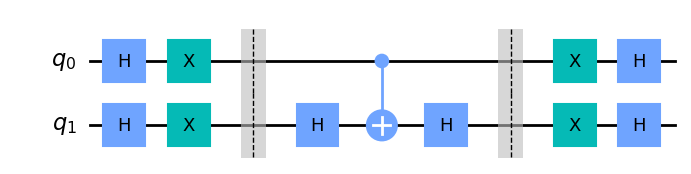

In [ ]:
print('Do you want to construct matrix for Grover operator (y/n)')
ans = 'n' #input()
if ans == 'y' or ans == 'Y':
    Grover_op = (2/d)*ones(d)-eye(d)

    for increment in range(d, 2**m):
        Grover_op = Grover_op.col_insert(increment, Matrix([0 for i in range(increment)]))
        Grover_op = Grover_op.row_insert(increment, Matrix([[0 for i in range(increment)]+[-1]]))
    Grover = QuantumCircuit(m, name = 'Grover')
    Grover.append(Operator(np.matrix(Grover_op)),range(m))
elif m>1:
    Grover = QuantumCircuit(m, name = 'Grover')
    Grover.h(range(m))
    Grover.x(range(m))
    Grover.barrier()
    Grover.h(m-1)
    Grover.append(XGate().control(m-1),[i for i in range(m)])
    Grover.h(m-1)
    Grover.barrier()
    Grover.x(range(m))
    Grover.h(range(m))
elif m==1:
    Grover = QuantumCircuit(1, name = 'Grover')
    Grover.h(0)
    Grover.x(0)
    Grover.z(0)
    Grover.x(0)
    Grover.h(0)

backend = Aer.get_backend('statevector_simulator')
job = execute(Grover, backend)
result = job.result()
v = result.get_statevector()
print(v)

# Grover = Grover.decompose()
Grover.draw('mpl')

[5, 4] [3, 2, 1, 0] [1, 0]


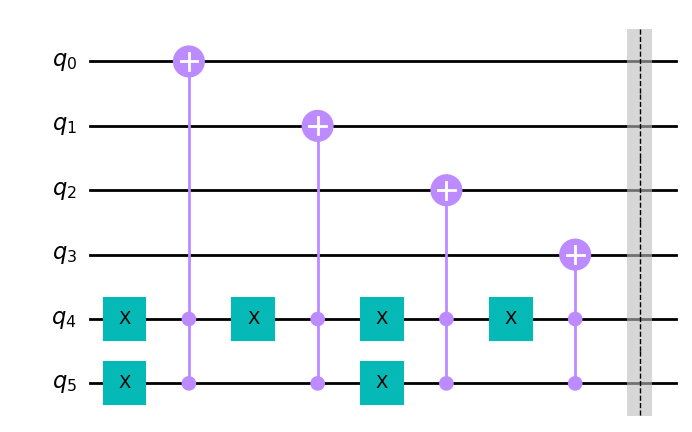

In [ ]:
### we will move from 000 towards 111, instead reverse
Shift_op = QuantumCircuit(n+m, name = 'Shift')
control_qubits = [n+m-1-i for i in range(m)]
state_qubits = [n-1-i for i in range(n)]
coin_qubits = [m-1-i for i in range(m)]

print(control_qubits, state_qubits, coin_qubits)

balance_X = [0]*m
for i in range(d): ###Gen_set, labelling done from 0 to d-1
    edge_label = Gen_set[i]
    target_qubits = [int(x) for x in str(bin(edge_label)[2:].zfill(n))] ###vertex qubits
    control_X = [int(x) for x in str(bin(i)[2:].zfill(m))]  ###shifts for 1
    #print(i,'\t',edge_label,'\t',control_X,'\t',target_qubits)

    for x in coin_qubits:
        Shift_op.x(n+m-1-x)
        balance_X[x] = balance_X[x]^1
        #print(x,':\tbalanced X:',balance_X)
        if control_X[x] == 1:
            break
    for target in state_qubits:
        if target_qubits[target] == 1:
            Shift_op.append(XGate().control(m), control_qubits + [n-1-target])

Shift_op.barrier()
for balance in coin_qubits:
    if balance_X[balance] == 1:
        Shift_op.x(n+m-1-balance)

Shift_op.draw('mpl')

Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j,
             0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
             0. +0.j, 0. +0.j],
            dims=(2, 2, 2, 2))


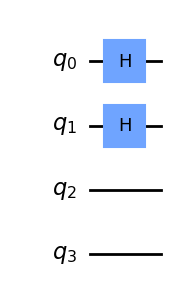

In [63]:
Coin_space = QuantumCircuit(m*k, name = 'Coin')

# initial_vector = [1/math.sqrt(d)]*d + [0]*(2**m-d)
# qc.initialize(initial_vector, range(n,n+m))

Coin_space.h(range(m))

# if k>1:
#     for i in range(m):
#         Coin_space.cx(i, range(i+m, k*m, m))

backend = Aer.get_backend('statevector_simulator')
job = execute(Coin_space, backend)
result = job.result()
v = result.get_statevector()
print(v)

Coin_space.draw('mpl')


Enter the starting number of step
0
Enter the ending number of step
15
no. of steps from:  0  to  15  are :  16
step = 0 statevector Statevector([0.5+0.j, 0. +0.j, 0. +0.j, ..., 0. +0.j, 0. +0.j, 0. +0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

step no.:  0
counts:  {'00000000': 1000}
no. of counts:  1
step = 1 statevector Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

step no.:  1
counts:  {'10000100': 66, '00010100': 66, '10000010': 58, '01000010': 64, '00011000': 71, '10000001': 56, '00100001': 69, '01001000': 63, '01000001': 75, '10001000': 67, '00010001': 68, '00100010': 53, '00010010': 54, '00100100': 54, '00101000': 61, '01000100': 55}
no. of counts:  16
step = 2 statevector Statevector([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

step no.:  2
counts:  {'00111010': 13, '00111001': 10, '01010101': 9, '10010011': 10, '010111

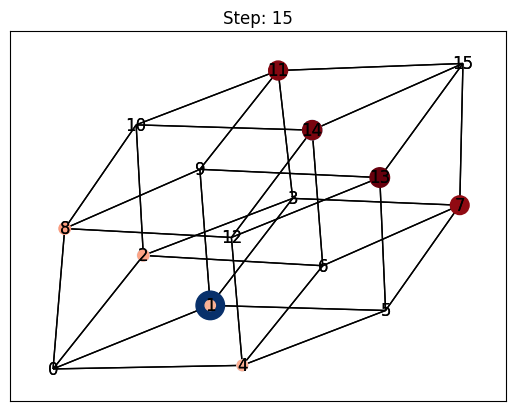

In [64]:
from qiskit.visualization.pulse.interpolation import step_wise
print('Enter the starting number of step')
first_step = int(input())
print('Enter the ending number of step')
last_step = int(input())
print('no. of steps from: ', first_step, ' to ', last_step, ' are : ', last_step-first_step+1)

Coin_qubits = [j for i in range(n,k*(n+m),n+m) for j in range(i,i+m)]

G = nx.Graph()
for edge in itertools.product(range(N),range(N)):
    value = edge[0]^edge[1]
    if value in Gen_set:
        G.add_edge(edge[0], edge[1])

list=[]
no_step = last_step-first_step+1
probabilities = {}
for i in range(k):
    step_dict = {}
    for j in range(no_step):
        state_dict = {}
        for kk in [format(node, '0' + str(n) + 'b') for node in G.nodes()]:
            state_dict[kk] = 0
        step_dict[j] = state_dict
    probabilities[i] = step_dict
# print('state_dict', state_dict)
# print('step_dict', step_dict)
# print('probabilities', probabilities)


for steps in range(first_step,last_step+1):
    qc = QuantumCircuit(k*(n+m),k*n)

    # for i in range(n):
    #     qc.x(i)

    qc.append(Coin_space, Coin_qubits)
    qc.barrier()

    for step in range(steps):
        for i in range(k):
            qc.append(Grover, range(i*(n+m)+n,(i+1)*(n+m)))
        qc.barrier()
        for i in range(k):
            qc.append(Shift_op, range(i*(n+m),(i+1)*(n+m)))
    qc.barrier()

    for i in range(k):
        for j in range(n):
            qc.measure(i*(m+n)+j,i*n+j)

    qc = qc.decompose()
    list.append(qc)

    # backend = Aer.get_backend('statevector_simulator')
    # job = execute(qc, backend)
    # result = job.result()
    # v = result.get_statevector()
    # print('step =',steps,'statevector',v)

    # Simulate the circuit and obtain the measurement results
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result()
    counts = result.get_counts()
    # print('\nstep no.: ', steps)
    # print('counts: ', counts)
    # print('no. of counts: ', len(counts))

    # Normalize the counts to obtain the probability distribution for this step

    total_counts = sum(counts.values())

    for whole_state, count in counts.items():
        for i in range(k):
            state = whole_state[i*n:(i+1)*n]
            # print('\n',i, state, 'probabilities[',i,']: ', probabilities)
            probabilities[i][steps][state] = probabilities[i][steps].setdefault(state,0) + count
            # print('\nprobabilities[',i,']: ', probabilities)

    for i in range(k):
    #     print('\nprobabilities: ', probabilities)
        for state in [format(node, '0' + str(n) + 'b') for node in G.nodes()]:
            probabilities[i][steps][state] = probabilities[i][steps].setdefault(state,0)/total_counts
    #     print('\nprobabilities: ', probabilities)
    # print(probabilities)


fig, ax = plt.subplots()
G_pos = nx.spring_layout(G, pos={0: [0,0], N-1:[1,1]}, fixed=[0,N-1])
node_color = [[0.1 for i in range(n)] for j in range(k)]
node_size = [[0 for i in range(n)] for j in range(k)]
for i in range(k):
    node_color[i] = [probabilities[i][steps].get(format(node, '0' + str(n) + 'b'), 0) for node in G.nodes()]
    node_size[i] = [1000*x for x in node_color[i]]
# print('step no =',first_step,'\n', node_size, node_color)
color = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Greys', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
for i in range(k):
    nx.draw_networkx(G, pos=G_pos, node_size=node_size[i], node_color=node_color[i], cmap=color[i], ax=ax)
ax.axis('off')

def update(steps):
    ax.clear()
    # probabilities[steps] = {'0': 0}
    node_color = [[0.1 for i in range(n)] for j in range(k)]
    node_size = [[0 for i in range(n)] for j in range(k)]
    for i in range(k):
        node_color[i] = [probabilities[i][steps].get(format(node, '0' + str(n) + 'b'), 0) for node in G.nodes()]
        node_size[i] = [1000*x for x in node_color[i]]
        # print('step =',steps,'\n', probabilities[i][steps],'\n', node_size, node_color)
    color = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Greys', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    # shape = ['^','v','>','<','d','p','h','8']
    for i in range(k):
        nx.draw_networkx(G, pos=G_pos, node_size=node_size[i], node_color=node_color[i], cmap=color[i], ax=ax)
    ax.set_title(f"Step: {steps}")

ani = FuncAnimation(fig, update, frames=range(first_step,last_step+1), interval=1000)
ani.save('test_animation.mp4', writer='ffmpeg')
plt.show()

# print('The Quantum Circuit for', last_step, 'number of steps')
# list[-1].draw('mpl')

In [65]:
from google.colab import files

# Download the animation file
files.download("test_animation.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
for i in range(len(v)):
    print(v[i])

<ipython-input-60-04d759574c30>:1: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i in range(len(v)):


0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0